In [7]:
# SIRT reconstruction for Phantom

import astra
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import random
import time
import pydicom
import glob
from numba import jit
from skimage import filters
import copy
from scipy import ndimage, misc

In [3]:
a       = sio.loadmat("/media/drilnvm/ubuntudata2/attenuation_values_cropped/LE/1.mat")["head"]
testvol = np.rollaxis(a, 2, 0)
testvol = np.moveaxis(testvol, [0, 1, 2], [0, 2, 1])

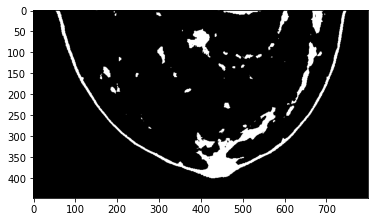

In [9]:
#plt.imshow()
#print(testvol.shape)
t1 = testvol > 0.7
plt.imshow(t1[160], cmap='gray')

(array([67072089.,        0.,        0.,        0., 28402305.,  8747808.,
         3962557.,  2359139.,  1605154.,  2538948.]),
 array([0.        , 0.09221424, 0.18442848, 0.2766427 , 0.36885697,
        0.4610712 , 0.5532854 , 0.64549965, 0.73771393, 0.82992816,
        0.9221424 ], dtype=float32),
 <BarContainer object of 10 artists>)

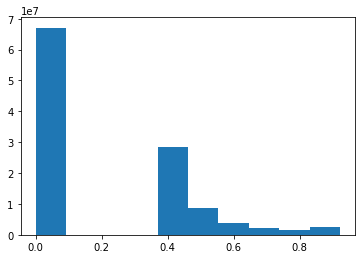

In [4]:
plt.hist(testvol.flatten())

In [ ]:



@jit(nopython=True, parallel=True)
def my_divide(x, y):
    return np.divide(x, y)

@jit(nopython=True, parallel=True)
def my_add(x, y):
    return np.add(x, y)

@jit(nopython=True, parallel=True)
def my_mul(x, y):
    return np.multiply(x, y)





#testvol = ndimage.zoom(testvol, 0.25, order=1)
#testvol = np.zeros([320, 448, 800], dtype='uint8')

scaling_factor = 1

SOD       = 65/0.025
ODD       = 4.5/0.025
detWidth  = 0.0085/0.025 #/(0.0255/scaling_factor)   # size of each detector pixel
detHeight = detWidth        # size of each detector pixel
detRows   = 3200
detCols   = 1600


num_angles = 25

#estimate = np.fromfile("/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/DBT_data/ClinicalExample/CE-05_R/ce.800x448x320.05-le.raw", dtype='float32')
#estimate = np.reshape(estimate, [320, 448, 800])


a       = sio.loadmat("/media/drilnvm/ubuntudata2/attenuation_values_cropped/LE/1.mat")["head"]
testvol = np.rollaxis(a, 2, 0)
testvol = np.moveaxis(testvol, [0, 1, 2], [0, 2, 1])
testvol = testvol/65.0


vol_geom = astra.create_vol_geom(int(testvol.shape[1]), int(testvol.shape[2]), int(testvol.shape[0]))
proj_arr = np.zeros((num_angles, detCols, detRows), dtype='float16')
testones = np.ones([int(testvol.shape[0]), int(testvol.shape[1]), int(testvol.shape[2])],  dtype='uint8')
estimate = np.zeros([int(testvol.shape[0]), int(testvol.shape[1]), int(testvol.shape[2])], dtype='float16')

print('Starting Recon')


#proj_arr = np.array(proj_arr).astype('float16')
#proj_arr = np.rollaxis(proj_arr, 1, 0)
#proj_arr = proj_arr.flatten()


# All Flags
recon_type       = 0
use_old_calci    = 0 # Use already generated calcifications
save_projections = 1 # Save the projections
insert_noise     = 1

# SIRT iteration LOOP
if recon_type == 0:
    niter      = 10
    start_time = time.time()
    
    for index in range(1, 176):
        print("Phantom ", index)
        a       = sio.loadmat("/media/drilnvm/ubuntudata2/attenuation_values_cropped/LE/"+str(index)+".mat")["head"]
        testvol = np.rollaxis(a, 2, 0)
        testvol = np.moveaxis(testvol, [0, 1, 2], [0, 2, 1])
        volume_mask = testvol > 0
        
        testvol = np.multiply(volume_mask, testvol)
        testvol = testvol/65.0
        
        ang = []
        for i in range(num_angles):
            ang.append(1.9)
        start_angle = -25#+np.random.randint(0, 3)
        theta       = []
        for i in range(num_angles):
            theta.append(start_angle*np.pi/180.0)
            start_angle = start_angle+ang[i]
        
        vectors = np.zeros((len(theta), 12))
        
        # For reconstructing real data
        vectors[:, 0:3]  = np.transpose(np.array([np.sin(theta), np.zeros(len(theta)), np.cos(theta)])) * SOD        # S source to object
        vectors[:,3:6]   = np.transpose(np.array([np.zeros(len(theta)), np.zeros(len(theta)),  -np.ones(len(theta))*ODD]))             # D object to detector
        vectors[:,6:9]   = np.transpose(np.array([np.ones(len(theta))*detWidth, np.zeros(len(theta)), np.zeros(len(theta))]))         # U
        vectors[:,9:12]  = np.transpose(np.array([np.zeros(len(theta)), np.ones(len(theta))*detWidth, np.zeros(len(theta))]))        # V

        # Creating the projection matrix
        proj_geom        = astra.create_proj_geom('cone_vec', detCols, detRows, vectors)
        proj_id          = astra.create_projector('cuda3d',   proj_geom, vol_geom)
        W                = astra.OpTomo(proj_id)
        
        proj_arr         = W*testvol
        
        temp_proj = np.reshape(proj_arr, [detCols, num_angles, detRows])
        temp_proj = np.rollaxis(temp_proj, 0, 2)
            
        # Saving the Projections
        if save_projections:
            I0             = 1400
            temp_proj      = I0*np.exp(-temp_proj)
            temp_proj[temp_proj == 0] = 1
            fid = open('/media/drilnvm/ubuntudata2/DENOISE-PROJ/'+str(temp_proj.shape[2])+'x'+str(temp_proj.shape[0])+'x'+str(temp_proj.shape[1])+'.'+str(index)+'-ground.raw', 'w')
            np.array(temp_proj).astype('float32').tofile(fid)
        
        # For inserting noise
        if(insert_noise):
            I0        = 1400
            proj      = I0*np.exp(-proj_arr)
            proj_noi  = np.random.poisson(proj)

            proj_noi[proj_noi == 0] = 1
            #g_noi                   = np.log(I0) - np.log(proj_noi) # convert back to line integrals 
            #g_noi[g_noi < 0]        = 0
            proj_arr = proj_noi#g_noi
        
        temp_proj  = np.reshape(proj_arr, [detCols, num_angles, detRows])
        temp_proj1 = temp_proj[:, 15:-15, :]
        
        # Saving the Projections
        if save_projections:
            fid = open('/media/drilnvm/ubuntudata2/DENOISE-PROJ/'+str(temp_proj.shape[2])+'x'+str(temp_proj.shape[0])+'x'+str(temp_proj.shape[1])+'.'+str(index)+'-noise1.raw', 'w')
            temp_proj  = np.rollaxis(temp_proj, 0, 2)
            np.array(temp_proj).astype('float32').tofile(fid)
        

In [4]:
a       = sio.loadmat("/media/drilnvm/ubuntudata2/attenuation_values_cropped/all_values.mat")
#a = '/media/drilnvm/ubuntudata2/attenuation_values_cropped/'
print(a)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Feb 14 12:52:46 2019', '__version__': '1.0', '__globals__': [], 'all_values': array([[0.45551   , 0.52649575, 0.61785268, 0.71263321, 0.80235   ,
        0.92214241],
       [0.45551   , 0.51807972, 0.60893056, 0.70338906, 0.80235   ,
        0.91468935],
       [0.45551   , 0.52454199, 0.61078663, 0.69423333, 0.80235   ,
        0.92675446],
       ...,
       [0.45551   , 0.50578268, 0.59473874, 0.66369154, 0.80235   ,
        1.13212209],
       [0.45551   , 0.45784418, 0.49933487, 0.53991314, 0.80235   ,
        1.72318494],
       [0.45551   , 0.53168523, 0.62442995, 0.70583201, 0.80235   ,
        0.90722706]])}


In [8]:
a = np.load('/media/drilnvm/ubuntudata2/DBTEx_numpy/train_vol_1071.npy')
print(a.shape)

(70, 750, 500)


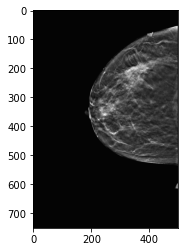

In [10]:
plt.imshow(a[35].astype('float32'), cmap='gray')

In [15]:
import pandas as pd

o1 = pd.read_pickle('train_target_1071.data')
o2 = pd.read_pickle('train_score_1071.data')
print(o1, o2)

[array([[307.53662, 184.97015, 352.89597, 255.1364 ],
       [300.27768, 178.87541, 370.8998 , 271.6027 ],
       [272.48297, 162.00409, 431.7771 , 274.20917]], dtype=float32), array([[308.00482, 184.53642, 352.48004, 249.05283]], dtype=float32), array([[301.44528, 181.16635, 376.41513, 269.31735]], dtype=float32), array([[299.372  , 176.42911, 384.47632, 270.84204],
       [309.34787, 183.67361, 359.84012, 263.037  ]], dtype=float32), array([], shape=(0, 4), dtype=float32), array([[297.36066, 171.8533 , 400.35983, 262.4136 ],
       [307.83987, 183.00179, 361.3783 , 258.19717]], dtype=float32), array([[282.13757, 159.85005, 437.6086 , 274.63193]], dtype=float32), array([[344.48724, 175.14305, 403.5407 , 208.51544],
       [279.20618, 162.41675, 427.27808, 282.32916]], dtype=float32), array([[293.16656, 166.78413, 402.27756, 286.041  ],
       [341.76843, 175.70268, 401.96832, 208.27539]], dtype=float32), array([[283.5822 , 157.63959, 434.08014, 281.3064 ],
       [344.09915, 175.97372

In [16]:
print(o1[0])
print(o2[0])

[[307.53662 184.97015 352.89597 255.1364 ]
 [300.27768 178.87541 370.8998  271.6027 ]
 [272.48297 162.00409 431.7771  274.20917]]
[0.3862559  0.25525072 0.10220138]


In [ ]:
I0        = 1400
proj      = I0*np.exp(-proj_arr)

proj_noi  = np.random.poisson(proj)

proj_noi[proj_noi == 0] = 1
#g_noi                   = np.log(I0) - np.log(proj_noi) # convert back to line integrals 
#g_noi[g_noi < 0]        = 0
proj_arr = proj_noi#g_noi